In [1]:
import numpy as np
import time
from multiprocessing import Pool

import matplotlib as mtl

mtl.use('nbAgg')
#mtl.use('Qt5Cairo')

import matplotlib.pyplot as plt

In [2]:

def FUNC(X):
    return X[0]
    #return np.exp(-100*(x[0]-0.4)**2)+(x[1]-0.6)**2+x[2]
    #return (X[1]-0.5)**7*np.sin((X[0]-0.5)*50)+0.001*np.cos((2*X[1]-0.5)*50)+X[0]*0.004
    #return X[0]+X[1]
#show(plot3d(lambda x,y:FUNC([x,y]),[0,1],[0,1]), figsize=3)
#show(plot3d(lambda x,y:FUNC([x,y]),[0,1.01],[0,1]))

In [3]:
a_damp=0.5 #you should play with it
x1=[0]*1
Dim=len(x1)
Ng=25
x1=[np.linspace(0,1,Ng) for i in np.arange(Dim)]#initial grid

##
#Ng=5
#x1=[np.array([0,0.001,0.2,0.9,1]),np.array([0,0.05,0.1,0.4,0.5])]
##
x=x1


<IPython.core.display.Javascript object>


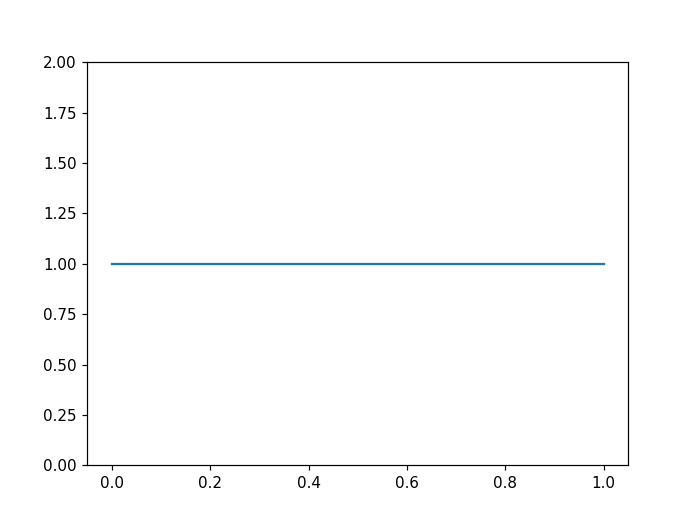

In [12]:
########### this is the effective distribution  the "1/(len(x[ind])-1)" is the normalization factor.
def dist_i(value,axis):
    grid_i=x[axis]
    #tmp= (np.abs(grid_i-value).argsort()[:2])#the np.abs is wrong here.
    #return 1/np.abs(grid_i[tmp[0]]-grid_i[tmp[1]])/(Ng-1)  #Ng=(len(x)-1) #this is p(x)=1/(N Δx_i) in Lepage's paper.
    
    if value>=1:
        tmp=Ng-1
    else:
        tmp= np.digitize(value,grid_i)
    return 1/np.abs(grid_i[tmp-1]-grid_i[tmp])/(Ng-1)  #Ng=(len(x)-1) #this is p(x)=1/(N Δx_i) in Lepage's paper.
   
                                            
                                            
dist_i=np.vectorize(dist_i)   
        
        
for i in range(Dim):
    
    plt.plot([g for g in np.linspace(0,1,100)],[dist_i(g,i) for g in np.linspace(0,1,100)])
    plt.ylim(0,2)
    
plt.show()

In [13]:
def Sample(axis,N_samples=100,xmin=0,xmax=1):
#Take N_samples  samples (in total) from grid according to the distributions.
    tmp_samples=[]
#HOW?
#It is easier than it sounds. Just draw the same number of points in each cell. 
#In this way, compared to the initial "uniform" grid, more points will be chosen in 
#the more dense regions!
    grid_i=x[axis]
    N_cells=Ng-1 #this is a global variable (it does not change)!
    cell_range=np.arange(N_cells)
    # N_per_cell, should be at least one!
    if N_samples<=N_cells:
        N_per_cell=1
    else:
        N_per_cell=int(N_samples/N_cells)
        
        
    if xmin>0 or xmax<1:
        for i in np.arange(N_per_cell):
            tmp_samples=np.append(tmp_samples, np.random.uniform(xmin,xmax))
        np.random.shuffle(tmp_samples) 
        
        return tmp_samples    
    
    for cell_i in cell_range:
        for i in np.arange(N_per_cell):
            x0=grid_i[cell_i]
            x1=grid_i[cell_i+1]
            tmp_samples=np.append(tmp_samples, np.random.uniform(x0,x1))
        np.random.shuffle(tmp_samples) #You need to shuffle them. 
                                       #Run without the shaffle, and you will understand.
                                       #In sort, you take all the small numbers with all the other 
                                       #small numbers and the big numbers with all the other big numbers.
    return tmp_samples




In [14]:
def Calculate_int_i(func,axis,xmin,xmax,N_samples=100): # (\bar{f}_i * Δx_i) for each axis
##---This function calculates the integral of f^2
#axis is the axis of interest.
#N= number of points to use.
#x0 and x1 are the points that define the current Δx_i.
    N_cells=Ng-1
    tmp_samples=[[]]*Dim
    #tmp_Indices=[[]]*Dim
    #tmp_Dists=[[]]*Dim
    tmp_prod_dist=1
    for run_dim in np.arange(Dim):
        if run_dim!=axis:
            tmp_samples[run_dim]=np.append(tmp_samples[run_dim],Sample(run_dim,N_samples))
            tmp_Indices=[run_dim]*len(tmp_samples[run_dim])
            tmp_prod_dist=tmp_prod_dist*dist_i(tmp_samples[run_dim],tmp_Indices)
        else:
            tmp_samples[run_dim]=np.append(tmp_samples[run_dim],np.tile(Sample(run_dim,N_samples,xmin,xmax),N_cells))
    
    return np.sqrt( np.mean(FUNC(np.array(tmp_samples))/tmp_prod_dist)**2 ) *(xmax-xmin)   
    #return np.sqrt( np.mean(FUNC(np.array(tmp_samples))/tmp_prod_dist)**2/(xmax-xmin) ) *(xmax-xmin)
    #return  np.mean(np.abs(FUNC(np.array(tmp_samples)))/tmp_prod_dist) *(xmax-xmin)


#Example
#print Calculate_int_i(FUNC,0,0,0.1,10**2)
#%timeit Calculate_int_i(FUNC,0,0,0.1,10**3)

In [15]:
def Calculate_int_sum(func,axis,N_samples=100): # Sum(\bar{f}_i*Δx_i)
    grid_i=x[axis]
    N_cells=Ng-1 #this is a global variable (it does not change)!
    cell_range=np.arange(N_cells)
    # N_per_cell, should be at least one!
    if N_samples<=N_cells:
        N_per_cell=1
    else:
        N_per_cell=int(N_samples/N_cells)
        
    tmp_int_sum=0    
    for cell_i in cell_range:
        x0=grid_i[cell_i]
        x1=grid_i[cell_i+1]        
        
        tmp_int_sum+=Calculate_int_i(func,axis,x0,x1,N_per_cell)
    
    return tmp_int_sum


#Example
#print Calculate_int_sum(FUNC,0,2*10**2)
#%timeit Calculate_int_sum(FUNC,0,10**3)

In [16]:
def Calculate_mi(func,axis,N_samples=100,K=10**3):
##---This function calculates m_i+1 for  x[axis], as defined in  Lepage's paper.  
#N= number of points to use in the evaluation of the integral of f^2.
#K= a constant #see Lepage's paper.
#func is the function to integrate.

    temp_mi=[]
    
    f_bar_dx_tot=Calculate_int_sum(func,axis,N_samples)
    grid_i=x[axis]
    
    N_cells=Ng-1
    cell_range=np.arange(N_cells)
    for cell_i in cell_range:
        x0=grid_i[cell_i]
        x1=grid_i[cell_i+1]
        f_bar_dx_i= Calculate_int_i(func,axis,x0,x1,N_samples)
        if f_bar_dx_i==0:
                temp_mi=  np.append(temp_mi,1)
        else:
            temp_mi=  np.append(temp_mi,1+int( K* ((f_bar_dx_i/f_bar_dx_tot-1)/(np.log(f_bar_dx_i)-np.log(f_bar_dx_tot)))**a_damp  ) ) #with damping
        #print temp_mi[cell_i], -x0+x1, x0
      
    return temp_mi
#Example
#a_damp=1
#print Calculate_mi(FUNC,0,10**3,10**5)
#new_grid_tot_faster(FUNC)
#%timeit Calculate_mi(FUNC,0,10**2,10**3)

In [17]:
def new_grid_axis(func,axis,N_samples=100,K=10**3):#calculate the new grid for  x[axis]
    temp_mi= Calculate_mi(FUNC,axis,N_samples,K)
    #print x
    N_cells=Ng-1
    cell_range=np.arange(N_cells)
    grid_i=x[axis]
    
    #a_tmp=1/np.sum(map(lambda i:(grid_i[i+1]-grid_i[i])/temp_mi[i]**2, cell_range ))#a_damp can absorb the **2  
    a_tmp=1/np.sum(map(lambda i:(grid_i[i+1]-grid_i[i])/temp_mi[i], cell_range ))
    list_new_dx_i=[]
    grid_tmp= [0]#The grid always starts at 0!
    for cell_i in cell_range:
        x0=grid_i[cell_i]
        x1=grid_i[cell_i+1]
        dx_i=x1-x0
        #new_dx_i= dx_i*a_tmp/temp_mi[cell_i]**2
        new_dx_i= dx_i*a_tmp/temp_mi[cell_i]
        grid_tmp=np.append(grid_tmp,grid_tmp[cell_i]+new_dx_i  )
        #print x0, dx_i, new_dx_i, temp_mi[cell_i]
    return grid_tmp



####!!!!!!!!!!!!!!!!!!!!!!!!!!!-problem-!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#after some point, some of the cells with smaller m_i acquire smaller dx, because dx_/temp_mi[cell_i]**2 is
#smaller than the corresponding value for the cells with larger dx. 


#new_grid_axis(FUNC,0,10**3,10**3)


In [18]:
def new_grid_tot(func,N_samples=100,K=10**3):
    tmp_new_grid_i=[]
    for run_dim in np.arange(Dim):
        #tmp_new_grid_i=np.append(tmp_new_grid_i,new_grid_axis(FUNC,run_dim,N_samples=100,K=10**3))
        tmp_new_grid_i.append(new_grid_axis(FUNC,run_dim,N_samples,K))
    return tmp_new_grid_i


#Example
'''in_time=time.time()
print 'Before:'
for i in range(Dim):
    show(plot(lambda g:dist_i(g,i),0,1), figsize=3)
print '========================================='

for r_b in range(10):
    x=new_grid_tot(FUNC)


print 'After:'
for i in range(Dim):
    show(plot(lambda g:dist_i(g,i),0,1), figsize=3)
print '========================================='
print time.time()-in_time,'s' ''';




def new_grid_tot_faster(func,N_samples=100,K=10**3):#faster convergense, since it uses the updated x[run_dim]
                                                                                   #to calculate x[run_dim+1]!
    global x
    for run_dim in np.arange(Dim):
        x[run_dim]=new_grid_axis(FUNC,run_dim,N_samples,K)

        
#a_damp=0.05
#print x[0]
#print Calculate_mi(FUNC,0,10**3,10**4)
#print new_grid_tot(FUNC)[0]


In [19]:
def total_Sample(N_samples=100):
#Take N_samples  samples (in total) from grid (in [0,1]) according to the distributions.
    tmp_samples=[]
#HOW?
#It is easier than it sounds. Just draw the same number of points in each cell. 
#In this way, compared to the initial "uniform" grid, more points will be chosen in 
#the more dense regions!
    N_cells=Ng-1
    cell_range=np.arange(N_cells)
    
    if N_samples<=N_cells:
        N_per_cell=1
    else:
        N_per_cell=int(N_samples/N_cells)
    
    tmp_samples=[[]]*Dim
    for run_dim in np.arange(Dim):
        grid_i=x[run_dim]
        for i in np.arange(N_per_cell):
            for cell_i in cell_range:
                
                x0=grid_i[cell_i]
                x1=grid_i[cell_i+1]
                tmp_samples[run_dim]=np.append(tmp_samples[run_dim], np.random.uniform(x0,x1))
        np.random.shuffle(tmp_samples[run_dim]) #You need to shuffle them. 
                                                #Run without the shaffle, and you will understand.
                                                #In sort, you take all the small numbers with all the other 
                                                #small numbers and the big numbers with all the other big numbers.
                                                
    return tmp_samples
#total_Sample()
#%timeit total_Sample()

In [20]:
def tot_int(func,N_samples=100):
    #print x[0][10]#uncomment this to see if the grid gets updated.
    tmp_samples=total_Sample(N_samples)
    #tmp_Indices=[[]]*Dim
    tmp_prod_dist=1
    for run_dim in np.arange(Dim):
            #tmp_samples[run_dim]=np.append(tmp_samples[run_dim],Sample(run_dim,N_samples))
            
            tmp_Indices=[run_dim]*len(tmp_samples[run_dim])
            tmp_prod_dist=tmp_prod_dist*dist_i(tmp_samples[run_dim],tmp_Indices)
         
    return np.mean(FUNC(np.array(tmp_samples))/tmp_prod_dist)  
    #return tmp_prod_dist  

#print tot_int(FUNC,10**3)
#%timeit tot_int(FUNC,10**3)

In [135]:
test=1
if test==1:
    ###### initialize the  grid:
    x1=[0]*2#this should correspond to number of dimensions
    Dim=len(x1)
    Ng=50
    x1=[np.linspace(0,1,Ng) for i in np.arange(Dim)]#initial grid
    x=x1
    ##########

    ##### Choose a function
    def FUNC(X):
        #return np.exp(-10*(X[0]-0.75)**2)
        #return 1/((X[0]-0.3)**2+0.001 )
        #return np.exp(-100*(X[0]-0.4)**2)+(X[1]-0.6)**2+X[2]
        #return (X[1]-0.5)**7*np.sin((X[0]-0.5)*50)+0.001*np.cos((2*X[1]-0.5)*50)+X[0]*0.004
        return np.exp(-(X[0]-0.6)**2/(2*0.2**2))*np.exp(-(X[1]-0.6)**2/(2*0.08**2))
        
    ####### define a dummy function that is used for pool.map
    def dummy(grid,N_samples=10**3):

        return tot_int(FUNC,N_samples)
    ######



    ######
    in_time=time.time()
    print 'Before:'
    #for i in range(Dim):    
    #    plt.plot([g for g in np.linspace(0,1,100)],[dist_i(g,i) for g in np.linspace(0,1,100)])
    #    plt.ylim(0,2)

    N_run=50
    N_b=2
    tot=map(dummy,[x]*N_b)
    print np.mean(tot), '+/-', np.sqrt(np.var(tot,ddof=1))/np.mean(tot)*100,'%'
    print '========================================='
    

    
    a_damp=0.1#you should play with it. Its value depends on the steepness of FUNC.
    for r_b in np.arange(N_run):
        #x=new_grid_tot(FUNC,5*10**2,10**5)
         
        new_grid_tot_faster(FUNC,10**2,10**3)
        
        #for i in range(Dim):   
            #plt.plot([g for g in np.linspace(0,1,100)],[dist_i(g,i) for g in np.linspace(0,1,100)])   
        #plt.show()
        

    print 'After:'
    #print 'look at the maxima. Do they correspond to the maxima of FUNC?'    
    print '========================================='
    print time.time()-in_time,'s' 


        
    tot=map(dummy,[x]*N_b)
    print np.mean(tot), '+/-', np.sqrt(np.var(tot,ddof=1))/np.mean(tot)*100,'%'
    
   

Before:
0.09835914616906438 +/- 6.473946386642039 %
After:
22.6704947948 s
0.09944108905635207 +/- 3.828268996785548 %


<IPython.core.display.Javascript object>


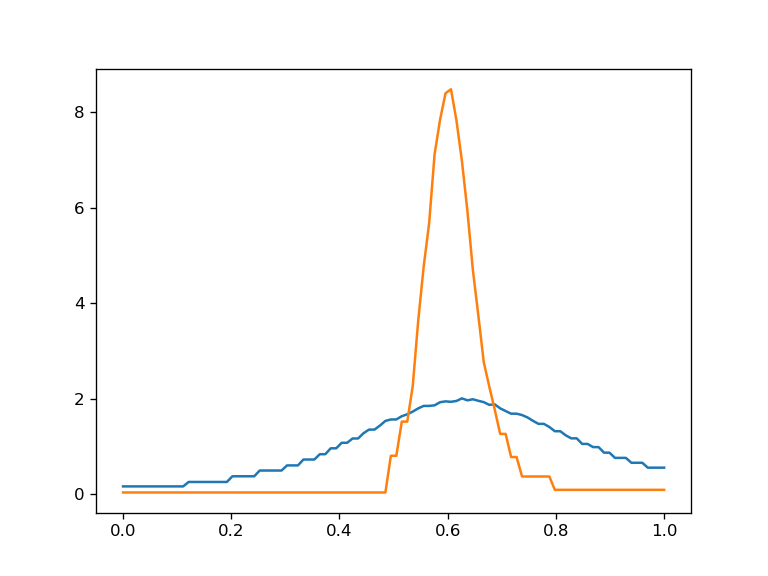

In [136]:
for i in range(Dim):
    plt.plot([g for g in np.linspace(0,1,100)],[dist_i(g,i) for g in np.linspace(0,1,100)])
plt.show()

<IPython.core.display.Javascript object>


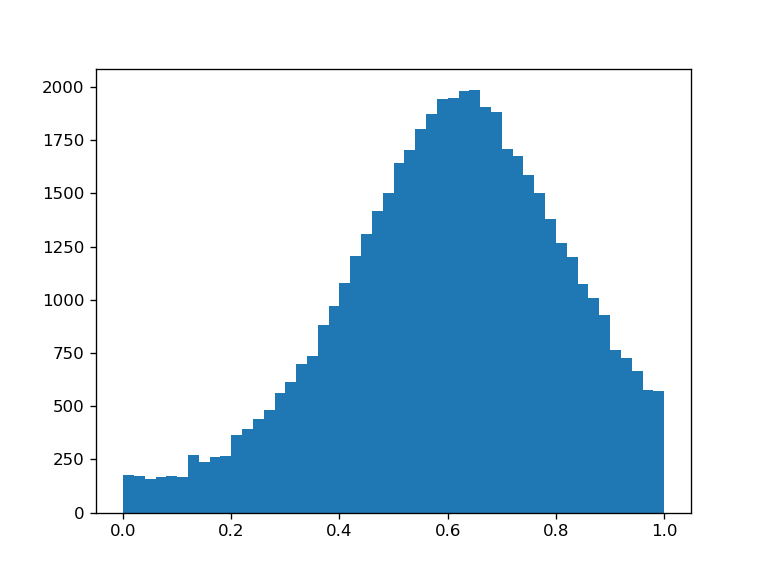

<IPython.core.display.Javascript object>


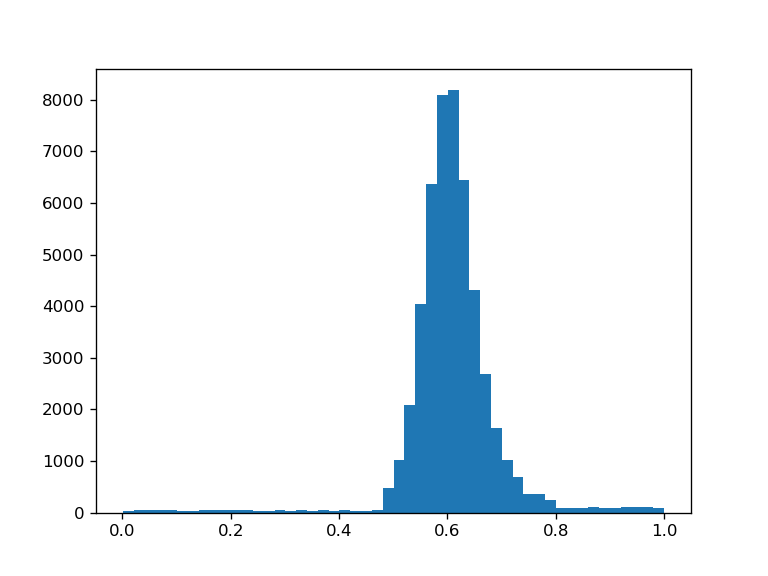

In [139]:
samples=total_Sample(1000*Ng)
for i in range(Dim):
    plt.hist(samples[i] , bins=Ng)
    plt.show()